In [1]:
import numpy as np
import numpyro
import numpyro.distributions as dist
from jax import random
from numpyro.infer import MCMC, HMC,NUTS
import fitsio
import matplotlib as mpl
from multiprocessing import Pool
from scipy.stats import dirichlet
from astropy.table import Table
from astropy.io import fits
import fitsio
from astropy.cosmology import Planck18
import jax.numpy as jnp
import matplotlib.pyplot as plt
from numpyro import handlers 
from jax import random, jit
import jax
from fitting import abs_mag_to_L,get_lfpars_shen20,T0,T1,T2,get_lfpars,get_phis,integral,integral_Lmin_Lmax
from jax import random, vmap
from jax.scipy.stats import norm
import numpyro.distributions as dist
from jax.scipy.special import gammaln
from astropy.cosmology import WMAP9 as cosmo
from scipy.optimize import curve_fit, brentq
import fitting
from tqdm import tqdm

2024-11-22 10:36:43.788430: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
jax.config.update("jax_enable_x64", True)

In [3]:
k = Table.read('/pscratch/sd/z/zhaozhon/DATASET/DESI-data/k.csv',format='csv')
indice = np.isnan(k['k_rr']) | np.isinf(k['k_rr'])
#k_gg = k['k_gg'][~indice]
k_rr = k['k_rr'][~indice]

In [4]:
file = '/pscratch/sd/z/zhaozhon/DATASET/DESI-data/new_d.fits'
d = Table(fitsio.read(file))
SEL = np.where((d['Z'] > 2.3) & (d['Z'] < 2.8))[0]
TARGETID = d['TARGETID'][SEL][~indice]
#apr_mag_g = d['APP_MAG_G'][SEL][~indice]
#apr_mag_g_err = d['APP_MAGERR_G'][SEL][~indice]
apr_mag_r = d['APP_MAG_R'][SEL][~indice]
apr_mag_r_err = d['APP_MAGERR_R'][SEL][~indice]
z_desi = d['Z'][SEL][~indice]
d_desi = Planck18.distmod(z_desi).value

In [5]:
TARGETID, indices = np.unique(TARGETID, return_index=True)
#apr_mag_g = apr_mag_g[indices]
#apr_mag_g_err = apr_mag_g_err[indices]
apr_mag_r = apr_mag_r[indices]
apr_mag_r_err = apr_mag_r_err[indices]
d_desi = d_desi[indices]
z_desi = z_desi[indices]
#k_gg = k_gg[indices]
k_rr = k_rr[indices]

In [6]:
# Assuming z_desi is your redshift array
filter_mask = (z_desi > 2.3) & (z_desi < 2.5)

# Apply the filter to all arrays
TARGETID = TARGETID[filter_mask]
#apr_mag_g = apr_mag_g[filter_mask]
#apr_mag_g_err = apr_mag_g_err[filter_mask]
apr_mag_r = apr_mag_r[filter_mask]
apr_mag_r_err = apr_mag_r_err[filter_mask]
d_desi = d_desi[filter_mask]
z_desi = z_desi[filter_mask]
#k_gg = k_gg[filter_mask]
k_rr = k_rr[filter_mask]

# Recalculate N_obs after filtering
N_obs = TARGETID.shape[0]
print(N_obs)

78837


In [7]:
apr_mag_r = apr_mag_r.astype(np.float64)
apr_mag_r_err = apr_mag_r_err.astype(np.float64)
k_rr = k_rr.astype(np.float64)

d_desi = d_desi.astype(np.float64)
z_desi = z_desi.astype(np.float64)

In [8]:
print(k_rr[0],d_desi[0],apr_mag_r_err[0])

-0.16798166842332596 46.50658918752716 0.027258500456809998


## Compare numerical df and analytical df

In [9]:
gamma1, gamma2, L_star, phi_star = get_lfpars("shen20",2.35)
alpha = -(gamma1+1)
beta = -(gamma2+1)
_, _, L_star, phi_star = get_lfpars_shen20((2.3+2.4)/2)
L_min = abs_mag_to_L(apr_mag_r.max()-k_rr.mean()-d_desi.mean()-1.7)/L_star
def eff(m):
    eff = jnp.where(m < 18.326392827473228, 1, 10**(-0.6586*(m-18.326392827473228)/2.5))
    return eff

df1 = fitting.discovery_fraction(eff)
discovery_fraction1 = df1(1.7, -25, k_rr, d_desi,apr_mag_r_err)
#discovery_fraction1 = df1(1.7, -25, -0.2386751981396219, 46.403933445021295,0.015071204863488674)

In [10]:
print(discovery_fraction1)

[[0.05742084 0.06375637 0.05718718 ... 0.05215113 0.0548327  0.05192355]]


In [11]:
df2 = fitting.discovery_fraction_exp(18.326392827473228,0.6586,-25+1.7+k_rr+d_desi,apr_mag_r_err)
#df2 = fitting.discovery_fraction_exp(18.326392827473228,0.6586,-25+1.7-0.2386751981396219+46.403933445021295,0.015071204863488674)
df3 = fitting.df_analytic(18.326392827473228,0.6586,-25+1.7+k_rr+d_desi,apr_mag_r_err)
#df3 = fitting.df_analytic(18.326392827473228,0.6586,-25+1.7-0.2386751981396219+46.403933445021295,0.015071204863488674)

[[0.05742084 0.06375637 0.05718718 ... 0.05215113 0.0548327  0.05192355]]
[0.0573685  0.06372401 0.0571653  ... 0.05211376 0.05480745 0.05187881]
[0.0573685  0.06372401 0.0571653  ... 0.05211376 0.05480745 0.05187881]


(array([4.2549e+04, 2.1647e+04, 1.0240e+04, 3.2650e+03, 8.9000e+02,
        1.9300e+02, 3.8000e+01, 7.0000e+00, 4.0000e+00, 4.0000e+00]),
 array([1.00001903, 1.00085976, 1.0017005 , 1.00254124, 1.00338197,
        1.00422271, 1.00506344, 1.00590418, 1.00674492, 1.00758565,
        1.00842639]),
 <BarContainer object of 10 artists>)

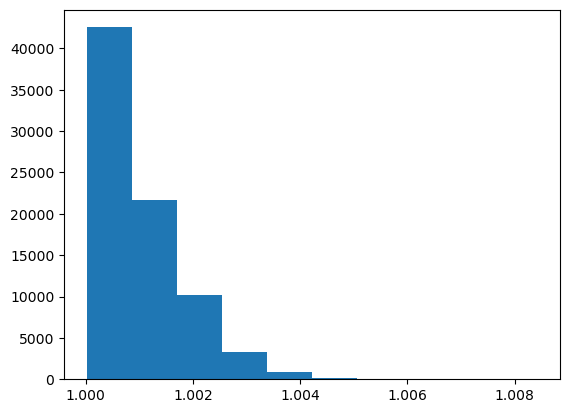

In [12]:
print(discovery_fraction1)
print(df2)
print(df3)
plt.hist(discovery_fraction1/df2)

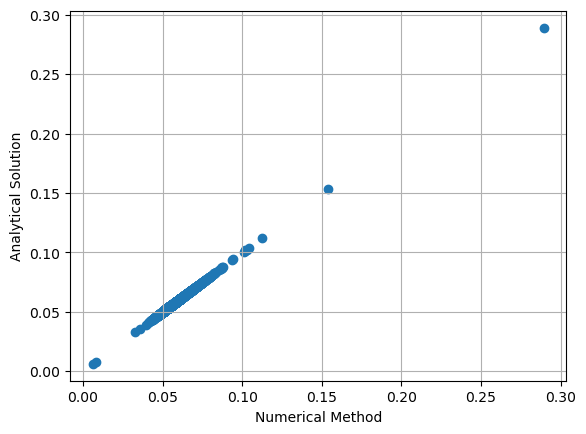

In [13]:
plt.scatter(discovery_fraction1,df3)
plt.xlabel("Numerical Method")
plt.ylabel("Analytical Solution")
plt.grid()
plt.show()

In [14]:
print(df1(1.7, -25, 0, 0,0))
print(fitting.discovery_fraction_exp(18.326392827473228,0.6586,-25+1.7+k_rr+d_desi,apr_mag_r_err))

[[1.]]
[0.0573685  0.06372401 0.0571653  ... 0.05211376 0.05480745 0.05187881]


## Compare numerical integral and analytical integral

In [15]:
def integral_numerical(Lmin,Lmax,alpha,beta,Nsamples):
    new_L = jnp.linspace(Lmin,Lmax,Nsamples)
    integrand = 1/(new_L**-alpha+new_L**-beta)
    integral = jnp.trapezoid(integrand,new_L)
    return integral

In [16]:
alpha = -3.3
beta = -4.5
Nsamples = np.logspace(3,5,100).astype(int)
Outputs = np.zeros(len(Nsamples),dtype=float)
for i,Nsample in enumerate(Nsamples):
    Outputs[i] = integral_numerical(0.1,100,beta,alpha,Nsample)

77.5202296885486


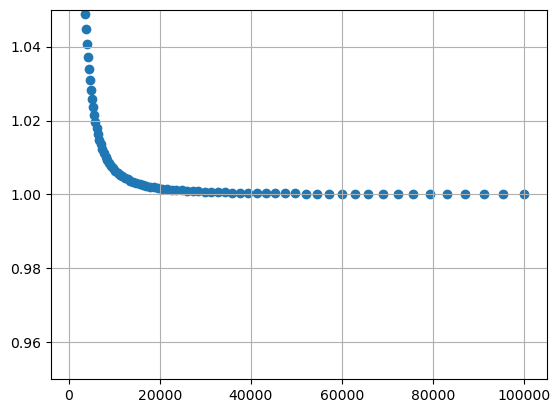

In [17]:
plt.scatter(Nsamples,Outputs/fitting.integral_Lmin_Lmax(0.1, 100, beta, alpha))
plt.ylim(0.95,1.05)
plt.grid()
print(Outputs[-1])

In [18]:
print(fitting.integral_Lmin_Lmax(0.1, 100, beta, alpha))

77.51496761967655


In [19]:
new_L1 = np.linspace(0.1,1,10)
integral1 = np.array([fitting.integral(x,alpha,beta) for x in new_L1])
new_L2 = np.linspace(1.1,2,10)
integral2 = np.array([fitting.integral(x,beta,alpha) for x in new_L2])
print(integral1[-1]-integral1[0])
print(integral2[-1]-integral2[0])
new_L = np.concatenate((new_L1,new_L2))
integral = np.concatenate((integral1,integral2))

77.34882089131452
0.09731003734013896


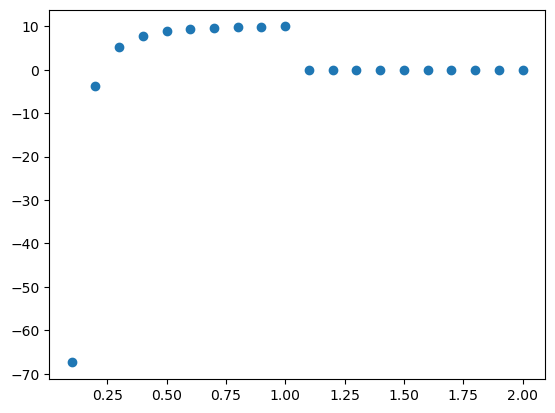

In [20]:
plt.scatter(new_L,integral)

## Check the precision of log_likelihood

In [21]:
def eff(m,b,m0):
    eff = jnp.where(m < m0, 1, 10**(-b*(m-m0)/2.5))
    return eff
Nsamples = np.linspace(1000,4000,10).astype(int)
Outputs = np.zeros(len(Nsamples),dtype=float)
for i,Nsample in tqdm(enumerate(Nsamples)):
    check_ln_posterior = fitting.check_ln_posterior(eff,2.3,2.5,Nsample)
    Outputs[i] = check_ln_posterior(19, 0.7, 0.74, apr_mag_r,k_rr,d_desi,apr_mag_r_err,0.08)

1it [00:03,  3.16s/it]

first term -109047.28314118655
Poisson term 808718.9875846851
N_obs 94291.78293298476


2it [00:05,  2.79s/it]

first term -108929.12411806028
Poisson term 808718.9875846851
N_obs 94291.78293298476


3it [00:08,  2.72s/it]

first term -108944.55272662512
Poisson term 808718.9875846851
N_obs 94291.78293298476


4it [00:11,  2.83s/it]

first term -108994.62542141236
Poisson term 808718.9875846851
N_obs 94291.78293298476


5it [00:14,  2.78s/it]

first term -109022.71280475584
Poisson term 808718.9875846851
N_obs 94291.78293298476


6it [00:16,  2.78s/it]

first term -109029.13983205229
Poisson term 808718.9875846851
N_obs 94291.78293298476


7it [00:19,  2.82s/it]

first term -108980.60759945701
Poisson term 808718.9875846851
N_obs 94291.78293298476


8it [00:22,  2.85s/it]

first term -108955.6185317517
Poisson term 808718.9875846851
N_obs 94291.78293298476


9it [00:25,  2.86s/it]

first term -108945.7004278957
Poisson term 808718.9875846851
N_obs 94291.78293298476


10it [00:28,  2.87s/it]

first term -108947.83687702025
Poisson term 808718.9875846851
N_obs 94291.78293298476


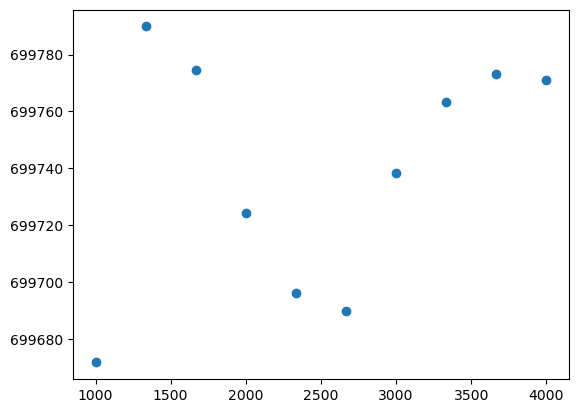

In [22]:
plt.scatter(Nsamples,Outputs)